# Implementação de algoritmo para usar as classes de simulação de array de microfones e GSC para o SESA Dataset

A ideia desse jupyter é criar um algoritmo que, dadas a pasta de origem e as de destino, simule um array de microfones com os áudios da pasta de origem e salve os sinais sem beamforming, com beamforming e com GSC nas pastas de destino.

In [1]:
import os
import librosa
import math
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio

#### Importando as classes criadas

In [2]:
import sys
sys.path.append('/home/dimi/Programming/IC2019/DOA/Python')

from GeneralizedSidelobeCancellerClass import GeneralizedSidelobeCanceller
from SimularArrayMicrofonesClass import SimularArrayMicrofones

## Definindo uma boa amplitude para o ruído

Pela definição, se a média do sinal for 0, pode-se aproximar a energia do sinal pela variância. A SNR pode ser definida como 10 * log_10 (var(sinal)/var(ruído)).

"Engineers consider a SNR of 2 (3 dB) to be the boundary between low and high SNRs".

http://www.scholarpedia.org/article/Signal-to-noise_ratio

In [3]:
def calcularSNR(sinal, ruido):
    return 10 * math.log((np.var(sinal)/np.var(ruido)), 10)

A função abaixo é exatamente a mesma que está sendo usada na classe SimularArrayMicrofones. Essa parte do jupyter vai servir apenas para achar uma boa SNR para realizar os testes.

In [4]:
def gerarRuidoBranco(qtdAmostras, energiaRuido):

    media        = 0
    desvioPadrao = 1

    return np.random.normal(media, desvioPadrao, size=qtdAmostras) * energiaRuido**(1/2)

O sinal que será aberto para fazer o teste **JÁ DEVE ESTAR NORMALIZADO PELA ENERGIA**, assim, fica muito mais fácil calcular a SNR.

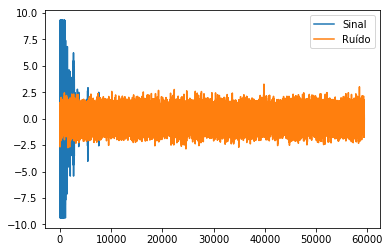

In [5]:
caminho = "/home/dimi/Downloads/Datasets/SESA/SESA_Normalizado/test/gunshot_019.wav"
sinalOriginal, freqAmostragem = librosa.load(caminho, sr=None, mono=True)
ruido = gerarRuidoBranco(len(sinalOriginal), 0.5)

plt.plot(sinalOriginal, label="Sinal")
plt.plot(ruido, label="Ruído")
plt.legend()
plt.show()

In [6]:
print("Energia do sinal:", np.var(sinalOriginal))
print("Energia do ruído:", np.var(ruido))
print("SNR:\t\t ", calcularSNR(sinalOriginal, ruido))

Energia do sinal: 0.9999999
Energia do ruído: 0.49543945216004565
SNR:		  3.0500936145422313


In [7]:
print("Original")
Audio(data=sinalOriginal, rate=freqAmostragem)

Original


In [ ]:
print("Com ruído")
sinalComRuido = sinalOriginal + ruido
Audio(data=sinalComRuido, rate=freqAmostragem)

## Rodando o algoritmo

#### Definindo os parâmetros iniciais desse algoritmo

In [ ]:
pastaOrigem                = '/home/dimi/Downloads/Datasets/SESA/SESA_Normalizado/test/'
pastaDestinoSemBeamforming = '/home/dimi/Downloads/Datasets/SESA/SESA_Normalizado/outros/SNR_3dB/testeSemBeamforming/'
pastaDestinoBeamforming    = '/home/dimi/Downloads/Datasets/SESA/SESA_Normalizado/outros/SNR_3dB/testeBeamforming/'
pastaDestinoGSC            = '/home/dimi/Downloads/Datasets/SESA/SESA_Normalizado/outros/SNR_3dB/testeGSC/'

#### Definindo os parâmetros iniciais da classe de simulação de array de microfones

In [ ]:
qtdMics      = 4
energiaRuido = 0.5

#### Rodando o algoritmo

In [ ]:
# LISTANDO OS ARQUIVOS NO DIRETORIO DE ORIGEM
arrayArquivos = os.listdir(pastaOrigem)
totalArquivos = len(arrayArquivos)

# CRIANDO UM ARRAY PRA ARMAZENAR OS TEMPOS DE PROCESSAMENTO
arrayTempoProcessamentoGSC = []

# PARA CADA ARQUIVO NA PASTA DE ORIGEM
for i, arquivoAtual in enumerate(arrayArquivos):
    
        print("\n" + arquivoAtual + ": arquivo " + str(i+1) + " de " + str(totalArquivos) + " -> " + str(100*((i+1)/totalArquivos)) + "%")
        
        # EU SIMULO UM ARRAY DE MICROFONES
        caminhoArquivo = pastaOrigem + arquivoAtual
        objSimularArrayMics = SimularArrayMicrofones(caminhoArquivo, qtdMics, energiaRuido)
        arraySinaisSimulados, arrayDelays, freqAmostragem = objSimularArrayMics.obterResultado()
        
        # APLICO O BEAMFORMING E GSC
        objGSC = GeneralizedSidelobeCanceller(arraySinaisSimulados, arrayDelays)
        sinalSemBeamforming, sinalBeamformado, sinalFinalGSC = objGSC.obterSinaisResultantes()
        arrayTempoProcessamentoGSC.append(objGSC.tempoProcessamentoGSC)
        
        # E POR FIM SALVO NAS PASTAS DE DESTINO
        librosa.output.write_wav(pastaDestinoSemBeamforming + arquivoAtual, sinalSemBeamforming, freqAmostragem)
        librosa.output.write_wav(pastaDestinoBeamforming + arquivoAtual, sinalBeamformado, freqAmostragem)
        librosa.output.write_wav(pastaDestinoGSC + arquivoAtual, sinalFinalGSC, freqAmostragem)

#### Verificando como foi o tempo de processamento

In [ ]:
print("Tempo médio (seg):\t", np.mean(arrayTempoProcessamentoGSC))
print("Tempo mínimo (seg):\t", np.amin(arrayTempoProcessamentoGSC))
print("Tempo máximo (seg):\t", np.amax(arrayTempoProcessamentoGSC))
print("Desvio padrão (seg):\t", np.std(arrayTempoProcessamentoGSC))
print("Tempo total (min):\t", np.sum(arrayTempoProcessamentoGSC)/60)